# Simulation of HPL on Dahu

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_result(name):
    archive = zipfile.ZipFile(name)
    res = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    return res

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    result['filename'] = name
    info = get_yaml(name, 'info.yaml')
    installfile = info['installfile']
    result['model'] = installfile[8:10]  # filename of the form 'install_A1.yaml', so we get the 'A1'
    install_options = get_yaml(name, installfile)
    result['stochastic_cpu'] = install_options['stochastic_cpu']
    result['polynomial_dgemm'] = install_options['polynomial_dgemm']
    result['stochastic_network'] = install_options['stochastic_network']
    result['heterogeneous_dgemm'] = install_options['heterogeneous_dgemm']
    return result

simulation_files = [
        'nancy_2019-07-13_2001967.zip',
        'nancy_2019-07-13_2001968.zip',
        'nancy_2019-07-13_2001969.zip',
        'nancy_2019-07-13_2001971.zip',
        'nancy_2019-07-13_2001972.zip',
        'nancy_2019-07-13_2001973.zip',
        'nancy_2019-07-13_2001974.zip',
        'nancy_2019-07-13_2001975.zip',
]

reality_files = [
    '../hpl/grenoble_2019-07-13_1873992.zip',
]

dfsim = pandas.concat([read_sim_result(f) for f in simulation_files])
dfsim['mode'] = 'Simulation'

dfreal = pandas.concat([read_result(f) for f in reality_files])
dfreal['mode'] = 'Reality'

df = pandas.concat([dfsim, dfreal])
sizes = set(dfsim.matrix_size) & set(dfreal.matrix_size)
df = df[df.matrix_size.isin(sizes)]
df.head()

,application_time,bcast,block_size,cpu_utilization,depth,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept,filename,...,simulation_time,start_timestamp,stochastic_cpu,stochastic_network,stop_timestamp,swap,sys_time,thread_per_process,time,usr_time
0,186.531,1,256,1.00,1,42.0,42.0,42.0,42.0,nancy_2019-07-13_2001967.zip,...,1391.43,NaN,True,False,NaN,0,162.55,1,34.23,1230.16
1,262.769,5,128,0.99,0,42.0,42.0,42.0,42.0,nancy_2019-07-13_2001967.zip,...,2312.76,NaN,True,False,NaN,2,141.87,1,35.18,2169.30
2,194.589,4,256,0.99,0,42.0,42.0,42.0,42.0,nancy_2019-07-13_2001967.zip,...,1104.79,NaN,True,False,NaN,0,406.96,1,50.76,697.37
3,242.565,0,128,0.99,0,42.0,42.0,42.0,42.0,nancy_2019-07-13_2001967.zip,...,1927.69,NaN,True,False,NaN,0,217.98,1,38.11,1706.08
4,231.729,2,256,0.99,0,42.0,42.0,42.0,42.0,nancy_2019-07-13_2001967.zip,...,1834.58,NaN,True,False,NaN,2,104.02,1,37.44,1729.57


### Checking the parameters

In [2]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,block_size,mem_align,thread_per_process,proc_p,depth,proc_q,rfact,pfact,swap,process_per_node,bcast
0,256,8,1,32,1,32,0,1,0,32,1
1,128,8,1,32,0,32,2,2,2,32,5
2,256,8,1,32,0,32,1,0,0,32,4
3,128,8,1,32,0,32,1,1,0,32,0
4,256,8,1,32,0,32,1,1,2,32,2
5,128,8,1,32,1,32,2,2,0,32,1
6,128,8,1,32,0,32,0,2,1,32,0
7,256,8,1,32,0,32,2,1,1,32,4
8,256,8,1,32,0,32,0,1,1,32,2
9,256,8,1,32,0,32,2,2,1,32,2


In [3]:
dfsim[['stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm']].drop_duplicates()

,stochastic_cpu,polynomial_dgemm,stochastic_network,heterogeneous_dgemm
0,True,True,False,True


In [4]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-31" speed="1" core="32" bw="12.5GBps" lat="0.05us" loopback_bw="18.348422228142745GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

### Checking the patch in the new simulation

In [5]:
patches = set()
for row in dfsim.iterrows():
    filename = row[1].filename
    repos = get_yaml(filename, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    patches.add(hpl[0]['patch'])
assert len(patches) == 1
display(Markdown('```diff\n%s\n```' % patches.pop()))

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/auxil/HPL_dlacpy.c b/src/auxil/HPL_dlacpy.c
index 70ccbce..0fd833b 100644
--- a/src/auxil/HPL_dlacpy.c
+++ b/src/auxil/HPL_dlacpy.c
@@ -342,8 +342,6 @@ void HPL_dlacpy
 /*
  * End of HPL_dlacpy
  */
-#else
-   smpi_execute_normal_size(3.871806e-09, 1.328595e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/auxil/HPL_dlatcpy.c b/src/auxil/HPL_dlatcpy.c
index 50d71eb..8bdca86 100644
--- a/src/auxil/HPL_dlatcpy.c
+++ b/src/auxil/HPL_dlatcpy.c
@@ -397,8 +397,6 @@ void HPL_dlatcpy
 /*
  * End of HPL_dlatcpy
  */
-#else
-    smpi_execute_normal_size(4.893900e-09, 4.691039e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp01T.c b/src/pauxil/HPL_dlaswp01T.c
index dc0f8b3..e0d8879 100644
--- a/src/pauxil/HPL_dlaswp01T.c
+++ b/src/pauxil/HPL_dlaswp01T.c
@@ -251,8 +251,6 @@ void HPL_dlaswp01T
 /*
  * End of HPL_dlaswp01T
  */
-#else
-    smpi_execute_normal_size(7.547639e-09, 1.371708e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp02N.c b/src/pauxil/HPL_dlaswp02N.c
index ba461fc..d7345d9 100644
--- a/src/pauxil/HPL_dlaswp02N.c
+++ b/src/pauxil/HPL_dlaswp02N.c
@@ -204,8 +204,6 @@ void HPL_dlaswp02N
 /*
  * End of HPL_dlaswp02N
  */
-#else
-    smpi_execute_normal_size(2.822241e-08, 5.497050e-09, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp03T.c b/src/pauxil/HPL_dlaswp03T.c
index 8e54bfe..92c4665 100644
--- a/src/pauxil/HPL_dlaswp03T.c
+++ b/src/pauxil/HPL_dlaswp03T.c
@@ -185,8 +185,6 @@ void HPL_dlaswp03T
 /*
  * End of HPL_dlaswp03T
  */
-#else
-    smpi_execute_normal_size(3.775240e-09, 2.968320e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp04T.c b/src/pauxil/HPL_dlaswp04T.c
index 61dd638..8e05cf3 100644
--- a/src/pauxil/HPL_dlaswp04T.c
+++ b/src/pauxil/HPL_dlaswp04T.c
@@ -269,8 +269,6 @@ void HPL_dlaswp04T
 /*
  * End of HPL_dlaswp04T
  */
-#else
-   smpi_execute_normal_size(8.498957e-09, 2.218070e-09, ((double)M1)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 3, (int []){M0, M1, N});
    

diff --git a/src/blas/HPL_dgemm.c b/src/blas/HPL_dgemm.c
index dd235b7..ab40276 100644
--- a/src/blas/HPL_dgemm.c
+++ b/src/blas/HPL_dgemm.c
@@ -204,14 +204,14 @@ double random_halfnormal_shifted(double exp, double std) {
 }

 void smpi_execute_normal(double mu, double sigma) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0) {
         smpi_execute_benched(coefficient);
     }
 }

 void smpi_execute_normal_size(double mu, double sigma, double size) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0 && size > 0) {
         smpi_execute_benched(size * coefficient);
     }
    
```

### Checking that the real run has no temporal pattern

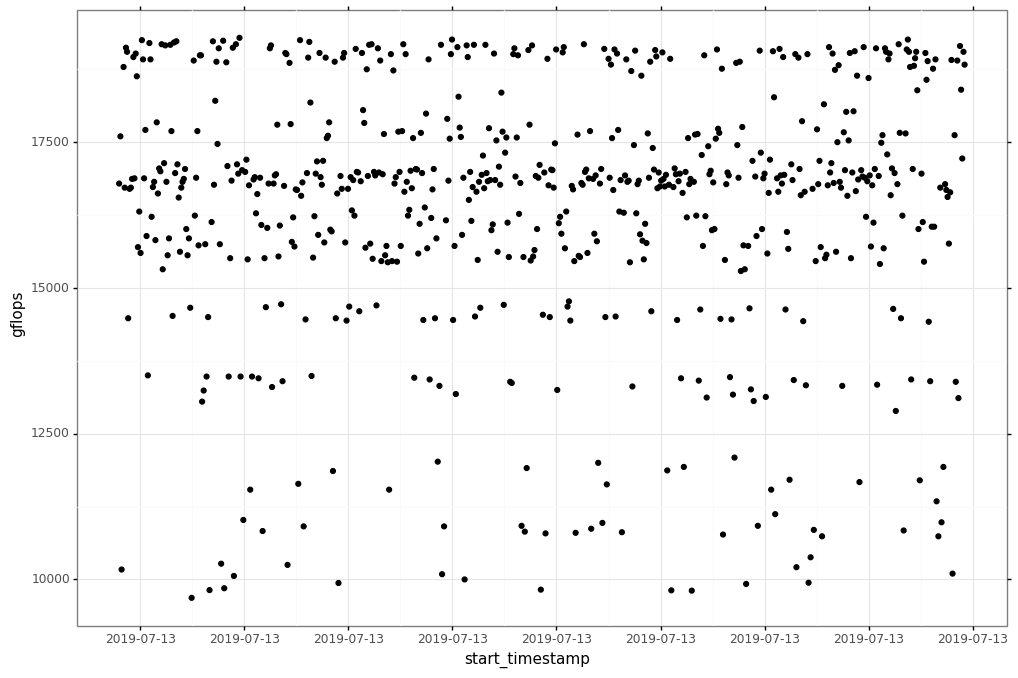

<ggplot: (8762561238164)>

In [6]:
dfreal['start_timestamp'] = pandas.to_datetime(dfreal['start_timestamp'])
ggplot(dfreal, aes(x='start_timestamp', y='gflops')) + geom_point() + theme_bw()

### Comparing the simulation with the real execution - ANOVA

In [7]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

def my_anova(df, factors, response):
    f_str = ['C(%s)' % fact for fact in factors if len(df[fact].unique()) > 1]
    formula = ' + '.join(f_str)
    formula = '(%s)**2' % formula
    formula = '%s ~ %s' % (response, formula)
    model = ols(formula, df).fit()
    aov_table = anova_lm(model, typ=2)
    aov_table['stars'] = ''
    aov_table.loc[aov_table['PR(>F)'] < 0.1 ,  'stars'] = '.'
    aov_table.loc[aov_table['PR(>F)'] < 0.05,  'stars'] = '*'
    aov_table.loc[aov_table['PR(>F)'] < 0.01,  'stars'] = '**'
    aov_table.loc[aov_table['PR(>F)'] < 0.001, 'stars'] = '***'
    return aov_table

In [8]:
factors = ['pfact', 'swap', 'bcast', 'depth', 'rfact', 'block_size']
my_anova(dfreal, factors, 'gflops').sort_values(by='F', ascending=False)

,sum_sq,df,F,PR(>F),stars
C(block_size),5.642504e+08,1.0,5052.086900,3.571469e-285,***
C(bcast),1.635701e+09,5.0,2929.091419,0.000000e+00,***
C(swap),2.231357e+08,2.0,998.936602,7.143045e-187,***
C(swap):C(bcast),5.905201e+08,10.0,528.729575,1.640955e-280,***
C(depth),4.817093e+07,1.0,431.304456,9.947122e-72,***
C(swap):C(depth),8.406808e+07,2.0,376.357048,7.342008e-105,***
C(depth):C(block_size),1.184303e+07,1.0,106.038084,6.422171e-23,***
C(swap):C(block_size),1.304356e+07,2.0,58.393567,8.581726e-24,***
C(bcast):C(depth),9.230669e+06,5.0,16.529591,2.975185e-15,***
C(bcast):C(block_size),2.895172e+06,5.0,5.184457,1.158040e-04,***


In [9]:
factors = ['pfact', 'swap', 'bcast', 'depth', 'rfact', 'block_size']
my_anova(dfsim, factors, 'gflops').sort_values(by='F', ascending=False)

,sum_sq,df,F,PR(>F),stars
C(block_size),4.610672e+08,1.0,619.706392,4.321739e-93,***
C(swap):C(depth),7.372667e+08,2.0,495.468826,2.457140e-125,***
C(depth),2.528501e+08,1.0,339.848074,7.502388e-60,***
C(bcast),9.681019e+08,5.0,260.239250,2.007060e-144,***
C(swap):C(bcast),4.028839e+08,10.0,54.150393,3.881657e-76,***
C(pfact),3.007528e+07,2.0,20.211632,3.311129e-09,***
C(rfact),1.150786e+07,2.0,7.733680,4.854508e-04,***
C(bcast):C(depth),1.968156e+07,5.0,5.290678,9.228635e-05,***
C(bcast):C(block_size),1.661241e+07,5.0,4.465647,5.331327e-04,***
C(pfact):C(depth),6.140904e+06,2.0,4.126901,1.661823e-02,*


### Comparing the simulation with the real execution - graphically

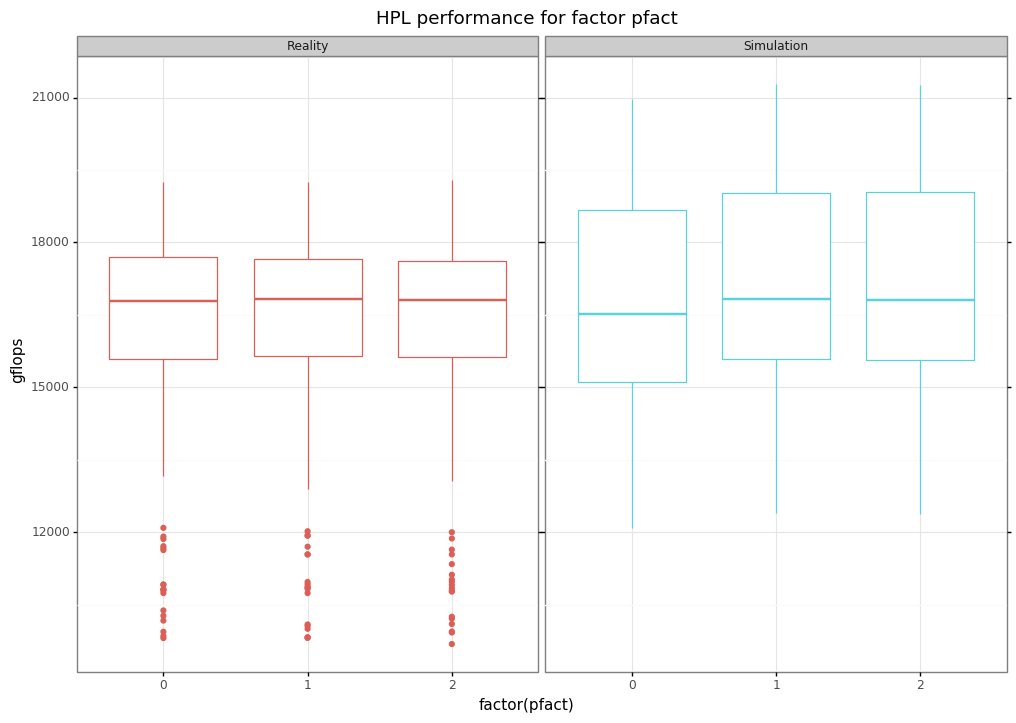

<ggplot: (8762508209777)>


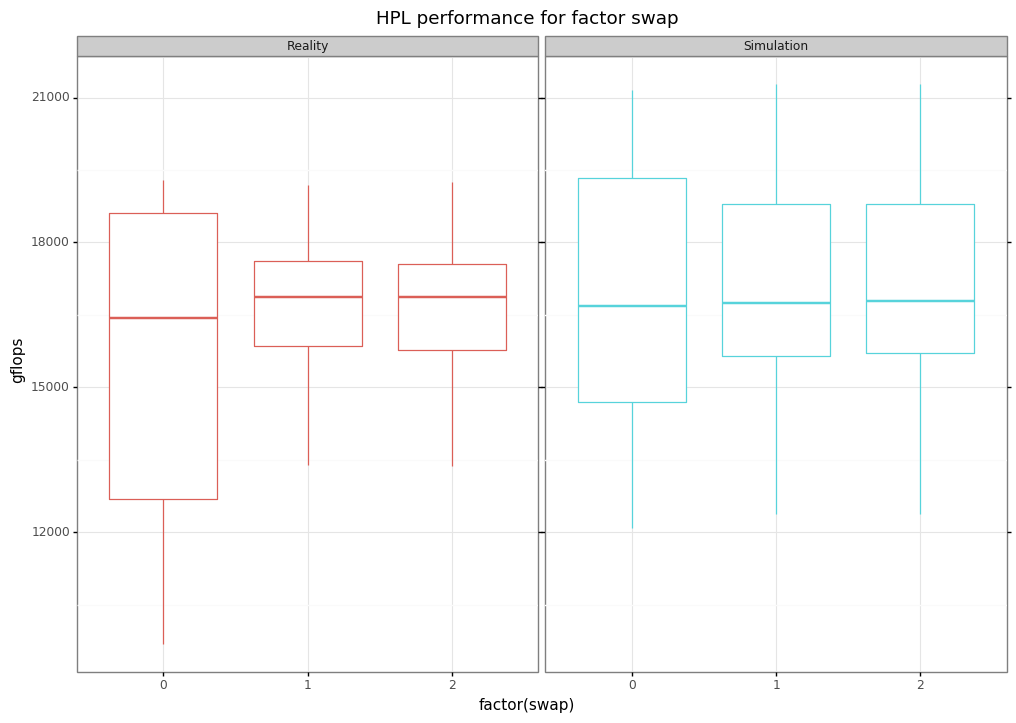

<ggplot: (8762508132998)>


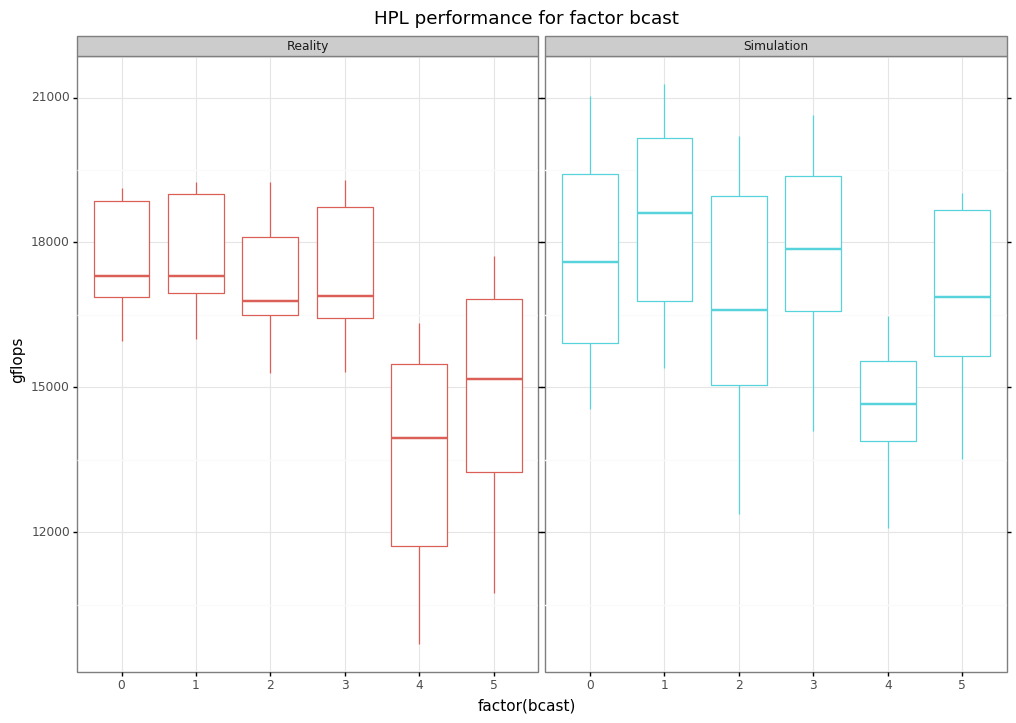

<ggplot: (-9223363274346635050)>


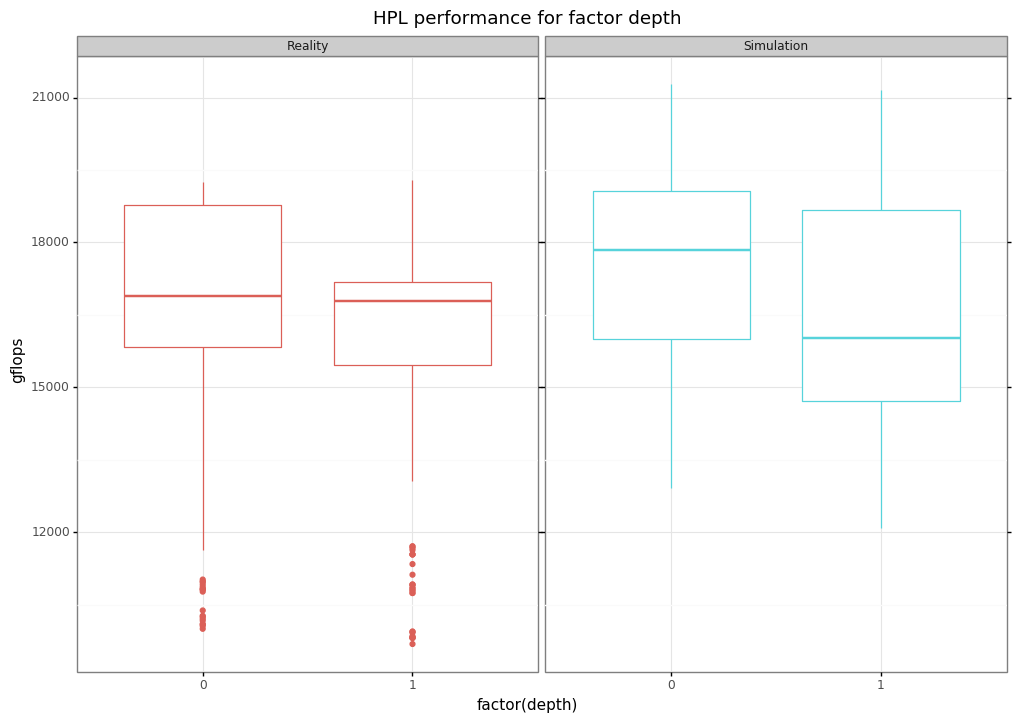

<ggplot: (8762508085880)>


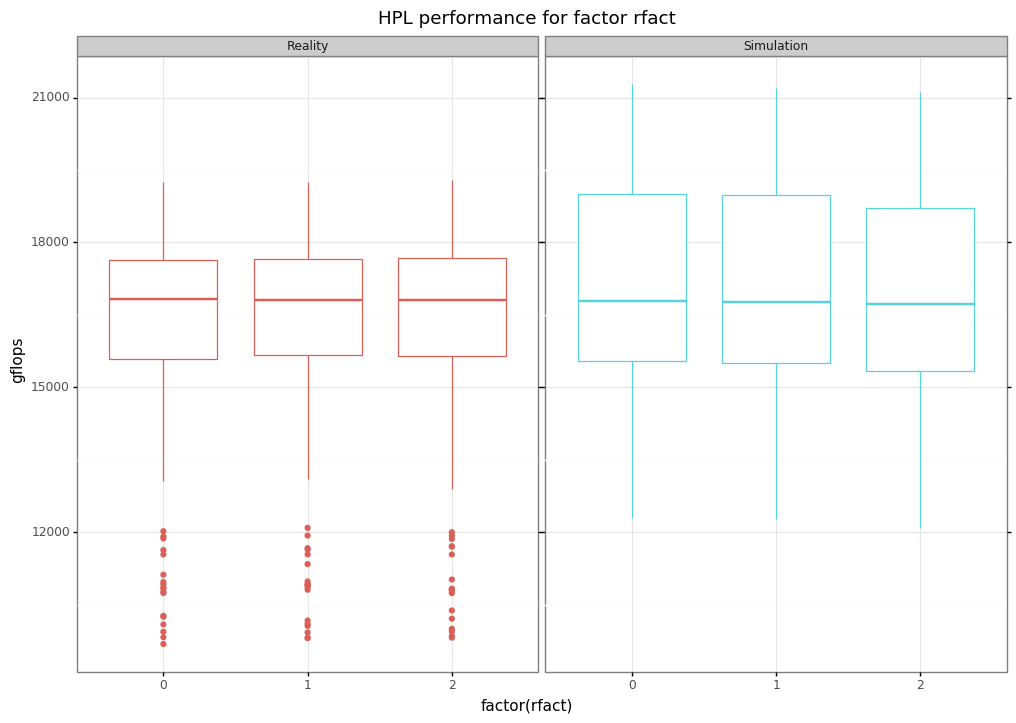

<ggplot: (8762506217862)>


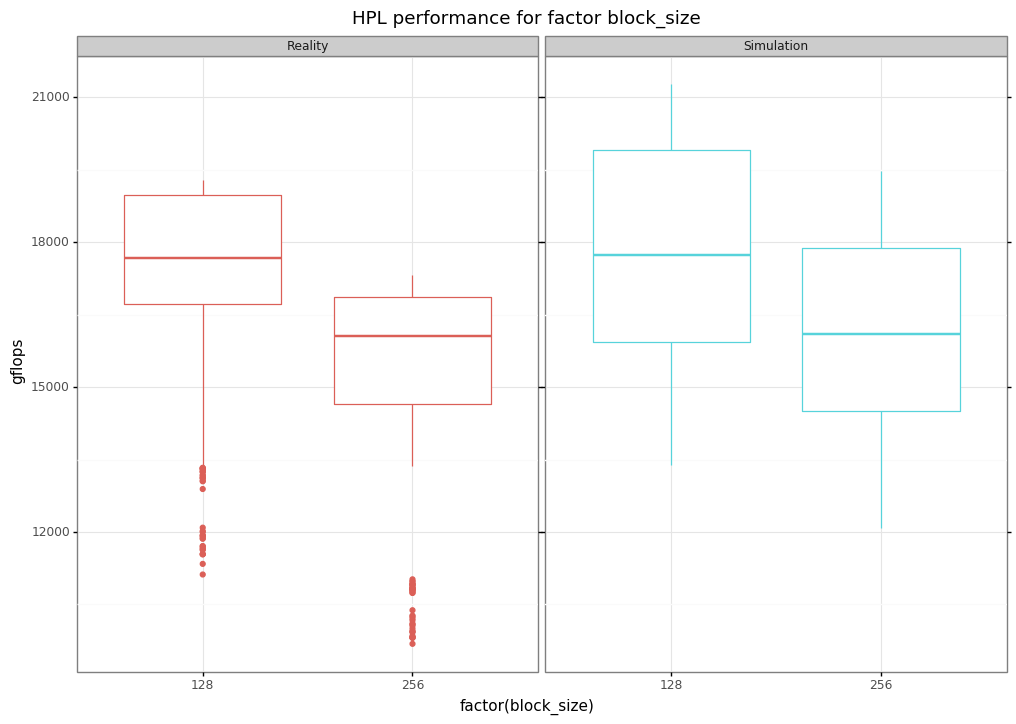

<ggplot: (-9223363274348564031)>


In [10]:
for fact in factors:
    plot = ggplot(df, aes(x='factor(%s)' % fact, y='gflops', group=fact, color='mode')) + geom_boxplot() + theme_bw() + facet_wrap('mode') + theme(legend_position='none') + ggtitle('HPL performance for factor %s' % fact)
    print(plot)

### Prediction error for individual factor combinations

In [11]:
grouped_real = dfreal.groupby(factors)[['gflops']].mean()
comparison = grouped_real.join(dfsim.set_index(factors), how='outer', lsuffix='_reality', rsuffix='_simulation').reset_index()
comparison['error'] = (comparison['gflops_simulation'] - comparison['gflops_reality'])/comparison['gflops_reality'] * 100
comparison['error'].describe()

count    648.000000
mean       4.868364
std       10.852108
min      -23.768473
25%       -3.065283
50%        5.672191
75%       10.979709
max       38.161560
Name: error, dtype: float64

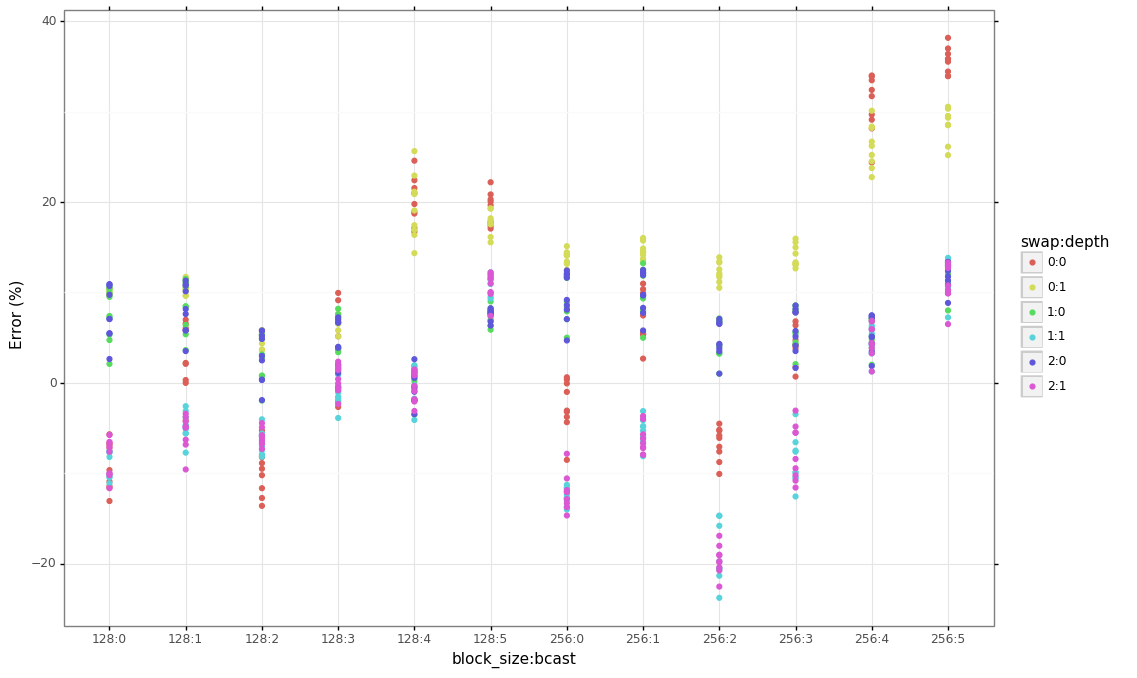

<ggplot: (8762506015766)>

In [12]:
def do_plot(df, y, x_factors, x_colors):
    tmp = df.copy()
    xfact = ':'.join(x_factors)
    xcol = ':'.join(x_colors)
    tmp[xfact] = tmp.apply(lambda row: ':'.join(str(row[fact]) for fact in x_factors), axis=1)
    tmp[xcol] = tmp.apply(lambda row: ':'.join(str(row[fact]) for fact in x_colors), axis=1)
    plot = ggplot(tmp, aes(x=xfact, y=y, color=xcol)) + geom_point() + theme_bw()
    return plot

do_plot(comparison, 'error', ['block_size', 'bcast'], ['swap', 'depth']) + ylab('Error (%)')

### Simulation efficiency

In [13]:
dfsim.simulation_time.describe()

count     648.000000
mean     1816.009761
std       640.232704
min       834.695000
25%      1412.467500
50%      1697.045000
75%      2111.480000
max      3645.420000
Name: simulation_time, dtype: float64

In [14]:
my_anova(dfsim, factors, 'simulation_time').sort_values(by='F', ascending=False)

,sum_sq,df,F,PR(>F),stars
C(block_size),8.600608e+07,1.0,3865.399128,7.225140e-256,***
C(depth),1.922974e+07,1.0,864.248398,3.086869e-116,***
C(bcast),7.748866e+07,5.0,696.519564,8.353725e-240,***
C(swap),2.293761e+07,2.0,515.446291,1.843317e-128,***
C(swap):C(block_size),1.763271e+07,2.0,396.236396,1.599148e-108,***
C(depth):C(block_size),4.430581e+06,1.0,199.125031,5.486033e-39,***
C(bcast):C(depth),1.010254e+07,5.0,90.808366,3.538119e-70,***
C(swap):C(depth),2.376429e+06,2.0,53.402297,5.563212e-22,***
C(bcast):C(block_size),4.301356e+06,5.0,38.663450,3.428175e-34,***
C(swap):C(bcast),7.763892e+06,10.0,34.893512,4.902767e-53,***


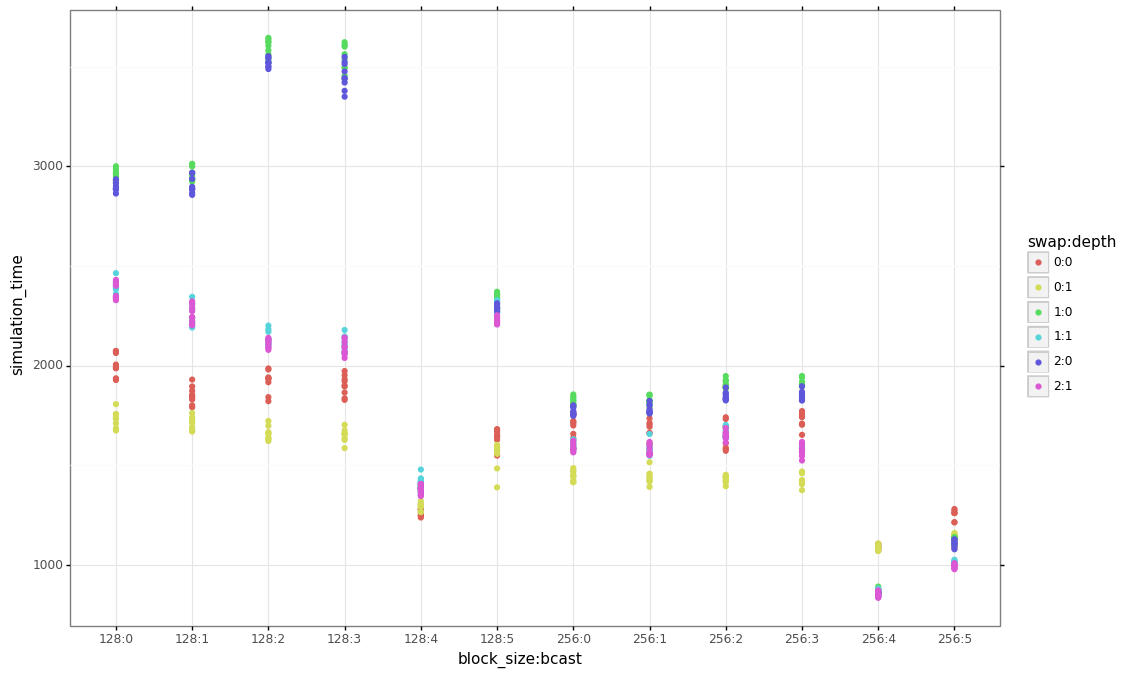

<ggplot: (-9223363274348869190)>

In [15]:
do_plot(dfsim, 'simulation_time', ['block_size', 'bcast'], ['swap', 'depth'])